In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import cluster
from sklearn import preprocessing
import sklearn.neighbors

# load models
import sys
sys.path.append('../')
from database.models import get_db_session, HierarchicalCluster
from database.models import NumericCluster as NCluster
from sqlalchemy import func

In [3]:
# Obtain the same attributes from the numeric clusters as in the PCA algorithm
session = get_db_session('sqlite:///../incidences.db')
accidents = session.query(NCluster.accidents, 
                          NCluster.nivel_medio, 
                          NCluster.carretera, 
                          NCluster.causa_ppal, 
                          NCluster.na_causa).all()

In [4]:
# Normalize the data
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(accidents)

In [5]:
# Obtain the average distance
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(data)
avSim = np.average(matsim)
print("%s\t%6.2f" % ('Average Distance', avSim))

Average Distance	  0.66


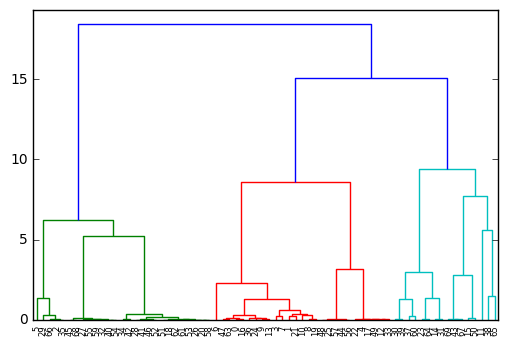

Number of clusters 3


In [6]:
# The best results are obtained with ward method
clusters = cluster.hierarchy.linkage(matsim, method='ward')
cluster.hierarchy.dendrogram(clusters, color_threshold=10)

# Plot the dendogram
plt.show()

# We choose a cut of 10
cut =(10)

labels = cluster.hierarchy.fcluster(clusters, cut, criterion = 'distance')

print ('Number of clusters %d' % (len(set(labels))))

In [10]:
def add_hierarchical_clusters(session, labels):
    clusters = session.query(NCluster).all()
    for index, cluster in enumerate(clusters):
        hier = HierarchicalCluster()
        hier.num_cluster = labels[index]
        hier.accidents = cluster.accidents
        hier.nivel_medio = cluster.nivel_medio
        hier.carretera = cluster.carretera
        hier.causa_ppal = cluster.causa_ppal
        hier.na_causa = cluster.na_causa
        session.add(hier)
    session.commit()

In [11]:
add_hierarchical_clusters(session, labels)